In [1]:
from planet import api
from planet.api import filters
from sys import stdout
import urllib.request
import shutil
from requests.auth import HTTPBasicAuth
import os
import time
import requests
import cv2
import glob
import subprocess
import rasterio
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [2]:
api_key = input("Please enter you Planet API key:") 

Please enter you Planet API key:fa8bc840c2af4b52a4f6a69e3489fd10


In [3]:
client = api.ClientV1(api_key) 
PL_API_KEY = api_key

In [4]:
geo_json_geometry = {
  "type": "Polygon",
        "coordinates": [
          [
            [
              105.35270690917969,
              -6.117683645476741
            ],
            [
              105.47595977783203,
              -6.117683645476741
            ],
            [
              105.47595977783203,
              -6.068183062989519
            ],
            [
              105.35270690917969,
              -6.068183062989519
            ],
            [
              105.35270690917969,
              -6.117683645476741
            ]
          ]
        ]
      }

In [5]:
geometry_filter = {
    "type": "GeometryFilter",
    "field_name": "geometry",
    "config": geo_json_geometry
}

In [6]:
date_range_filter = {
    "type": "DateRangeFilter",
    "field_name": "acquired",
    "config": {
        "gte": "2018-12-04T00:00:00.000Z",
        "lte": "2018-12-20T00:00:00.000Z"
    }
}

In [7]:
cloud_cover_filter = {
    "type": "RangeFilter",
    "field_name": "cloud_cover",
    "config": {
        "lte": 0.2,
    }
}

In [8]:
item_types = ['PSScene4Band']
asset_type = 'analytic'

In [9]:
query = {
    "type": "AndFilter",
    "config": [geometry_filter, date_range_filter, cloud_cover_filter]
}

In [10]:
request = filters.build_search_request(
    query, item_types
)

In [11]:
dataset = client.quick_search(request)

stdout.write('id,cloud_cover,date\n')

id,cloud_cover,date


In [12]:
for item in dataset.items_iter(limit=None):
    props = item['properties']
    stdout.write('{0},{cloud_cover},{acquired}\n'.format(item['id'], **props))

20181217_025142_101e,0.01,2018-12-17T02:51:42.296592Z
20181217_025143_101e,0.01,2018-12-17T02:51:43.330487Z
20181218_031148_0f33,0.17,2018-12-18T03:11:48.793389Z
20181218_031147_0f33,0.08,2018-12-18T03:11:47.844952Z


In [13]:
for i in item_types:
    request = api.filters.build_search_request(query, [i])  # ,name = None, interval= 'day')
    dataset = client.quick_search(request)
    print(i)
    for item in dataset.items_iter(limit=4):
        print(item['id'])
        session = requests.Session()
        session.auth = (PL_API_KEY, '')
        results = \
            session.get(
                ("https://api.planet.com/data/v1/item-types/" +
                 "{}/items/{}/assets/").format(i, item['id']))
       
        item_activation_url = results.json()[asset_type]["_links"]["activate"]
       
        response = session.post(item_activation_url)
        print(response.status_code)
        while response.status_code != 204:
            time.sleep(30)
            response = session.post(item_activation_url)
            response.status_code = response.status_code
            print(response.status_code)
        
        item_url = 'https://api.planet.com/data/v1/item-types/{}/items/{}/assets'.format(i, item['id'])
        result = requests.get(item_url, auth=HTTPBasicAuth(PL_API_KEY, ''))
        download_url = result.json()[asset_type]['location']  # KeyError: 'location'
        output_file = item['id'] + '.tif'

        with urllib.request.urlopen(download_url) as response, open(output_file, 'wb') as out_file:
            shutil.copyfileobj(response, out_file)

PSScene4Band
20181217_025142_101e
204
20181217_025143_101e
204
20181218_031148_0f33
204
20181218_031147_0f33
204


In [14]:
os.getcwd()
os.mkdir('Original_Imagery')

In [15]:
sp = os.getcwd()
sf = os.listdir(sp)
dp = sp + ('\\Original_Imagery')
for file in sf:
    if file.endswith('.tif'):
        shutil.move(os.path.join(sp,file), os.path.join(dp, file))

In [16]:
images = [f for f in os.listdir(dp) if os.path.isfile(os.path.join(dp, f))]

for image in images:
    folder_name = image.split('_')[0]

    new_path = os.path.join(dp, folder_name)
    if not os.path.exists(new_path):
        os.makedirs(new_path)

    old_image_path = os.path.join(dp, image)
    new_image_path = os.path.join(new_path, image)
    shutil.move(old_image_path, new_image_path)

In [17]:
folders = []
for r, d, f in os.walk(dp):
    for folder in d:
        folders.append(os.path.join(r, folder))

i = 0
for x in folders:
    files_to_mosaic = glob.glob(folders[i] + '/*.tif')
    files_string = " ".join(files_to_mosaic)
    command = "python " + sp + "\gdal_merge.py -o "+ files_string[-33:-25] + ".tif" + " -of gtiff " + files_string
    print(command)
    i = i + 1
    output = subprocess.getoutput(command)
    print(output)

python C:\Users\cengelso\Documents\IONS\gdal_merge.py -o 20181217.tif -of gtiff C:\Users\cengelso\Documents\IONS\Original_Imagery\20181217\20181217_025142_101e.tif C:\Users\cengelso\Documents\IONS\Original_Imagery\20181217\20181217_025143_101e.tif
0...10...20...30...40...50...60...70...80...90...100 - done.
python C:\Users\cengelso\Documents\IONS\gdal_merge.py -o 20181218.tif -of gtiff C:\Users\cengelso\Documents\IONS\Original_Imagery\20181218\20181218_031147_0f33.tif C:\Users\cengelso\Documents\IONS\Original_Imagery\20181218\20181218_031148_0f33.tif
0...10...20...30...40...50...60...70...80...90...100 - done.


In [18]:
os.mkdir('Merged_Tifs')

In [19]:
sp2 = os.getcwd()
sf2 = os.listdir(sp2)
dp2 = sp2 + ('\\Merged_Tifs')
for file in sf2:
    if file.endswith('.tif'):
        shutil.move(os.path.join(sp2,file), os.path.join(dp2, file))

In [20]:
os.chdir(sp2 + '\\Merged_Tifs')

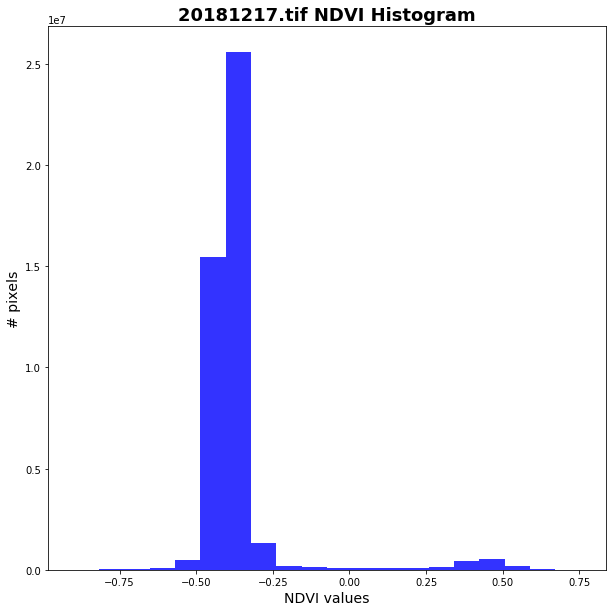

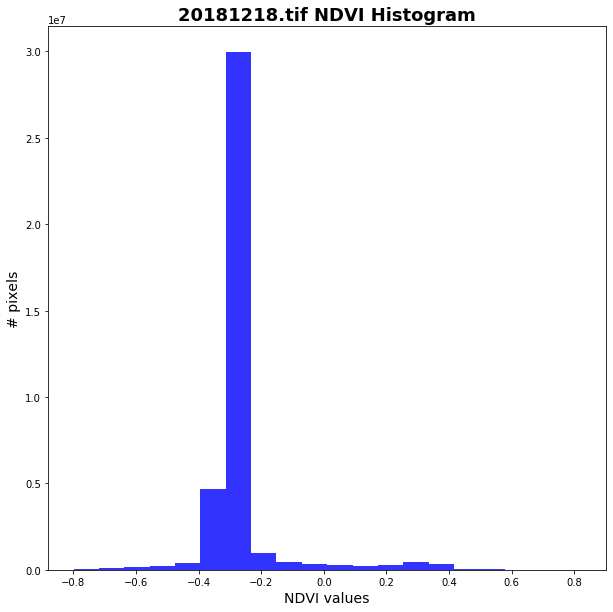

In [27]:
files = []
for r, d, f in os.walk(dp2):
    for file in f:
        files.append(os.path.join(r, file))
        

i = 0
for x in files:
    with rasterio.open(files[i]) as src:
            band_red = src.read(3)
    with rasterio.open(files[i]) as src:
            band_nir = src.read(4)
            
    np.seterr(divide='ignore', invalid='ignore')
    ndvi = ((band_nir.astype(float) - band_red.astype(float)) / (band_nir + band_red))
    
    
    kwargs = src.meta
    kwargs.update(
    dtype = rasterio.float32,
    count = 1)
    with rasterio.open('ndvi_' + f[i], 'w', **kwargs) as dst:
        dst.write_band(1, ndvi.astype(rasterio.float32))
        
    
    
    fig2 = plt.figure(figsize=(10,10))
    ax = fig2.add_subplot(111)
    
    plt.title(f[i] + " NDVI Histogram", fontsize=18, fontweight='bold')
    plt.xlabel("NDVI values", fontsize=14)
    plt.ylabel("# pixels", fontsize=14)
    
    b = ndvi[~np.isnan(ndvi)]
    numBins = 20
    ax.hist(b,numBins,color='blue',alpha=0.8)
    
    fig2.savefig("ndvi_" + f[i][0:8] + "_histogram.png", dpi=200, bbox_inches='tight', pad_inches=0.7)

    
    ndvi_adjusted = ndvi * (-255.0)
    masked_ndvi_adjusted = np.ma.array(ndvi_adjusted, mask=np.isnan(ndvi_adjusted))
    cmap = plt.cm.RdYlGn
    cmap.set_bad(color = 'white',alpha = 0.0)
    img = masked_ndvi_adjusted.astype(np.uint8)
    plt.imsave("ndvi_" + f[i][0:8] + "_colormap.tiff", img, cmap=cmap)
       
    i = i + 1

In [22]:
sp3 = os.getcwd()
sf3 = os.listdir(sp3)

for file in sf3:
    if file.startswith('ndvi'):
        shutil.move(os.path.join(sp3,file), os.path.join(sp2,file))

In [23]:
os.chdir(sp2)
os.mkdir('Vegetation_Indices')

In [24]:
sp4 = os.getcwd()
sf4 = os.listdir(sp4)
dp4 = sp2 + '\\Vegetation_Indices'

for file in sf3:
    if file.startswith('ndvi'):
        shutil.move(os.path.join(sp4,file), os.path.join(dp4,file))